## MCTS Validation

Minimal tests to verify the MCTS implementation in `pomdp.py` works correctly.


In [95]:
import importlib
import pomdp
importlib.reload(pomdp)

from pomdp import POMDP, MCTS
from ekf import State
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint


### Test 1: 1D Navigation

Simple test: agent at position ±5 should thrust toward origin (0).


In [2]:
def tro_1d(s, a):
    s_val = float(s[0]) if hasattr(s, '__len__') else float(s)
    s_next = s_val + a + np.random.normal(0, 0.1)
    r = -abs(s_next)  # reward = negative distance to origin
    o = round(s_next + np.random.normal(0, 0.5), 2)
    return s_next, r, o

problem_1d = POMDP(gamma=0.9, states=None, actions=[-1, +1], observations=None,
                   transition=None, reward=None, observation=None, tro=tro_1d)

# Test: position +5 should choose -1, position -5 should choose +1
for pos in [5.0, -5.0]:
    print(f"Pos {pos}")
    mcts = MCTS(problem_1d, depth=5, num_sims=100, c=1.0)
    belief = State(x=np.array([pos]), P=np.array([[1.0]]))
    action = mcts(belief)
    expected = -1 if pos > 0 else +1
    status = "✓" if action == expected else "✗"
    print(f"Position {pos:+.0f} → action {action:+d} (expected {expected:+d}) {status}")


Pos 5.0
Position +5 → action -1 (expected -1) ✓
Pos -5.0
Position -5 → action +1 (expected +1) ✓


### Test 2: 6D Orbital Rendezvous

Chaser satellite at [100, 0, 0] should thrust in -x direction toward target at origin.


In [103]:
def tro_6d(s, a):
    dt = 1.0
    pos, vel = s[:3], s[3:6]
    a = np.array(a)
    pos_next = pos + vel * dt + 0.5 * a * dt**2
    vel_next = vel + a * dt
    s_next = np.concatenate([pos_next, vel_next]) + np.random.normal(0, 0.01, 6)
    r = -np.linalg.norm(s_next[:3])  # reward = negative distance to origin
    o = tuple(np.round(s_next[:3] + np.random.normal(0, 0.1, 3), 1))
    return s_next, r, o

thrust = 0.1
actions_6d = [
    (thrust, 0, 0), (-thrust, 0, 0),
    (0, thrust, 0), (0, -thrust, 0),
    (0, 0, thrust), (0, 0, -thrust),
    (0, 0, 0),  # coast
]

actions_6d_to_index = {
    a:int(i) for i,a in enumerate(actions_6d)
}
index_to_actions_6d = {int(i):a for i,a in enumerate(actions_6d)}

problem_6d = POMDP(gamma=0.95, states=None, actions=actions_6d, observations=None,
                   transition=None, reward=None, observation=None, tro=tro_6d)

In [90]:
# Test: 10 runs from [100, 0, 0] - should mostly choose (-0.1, 0, 0)
results = []
num_runs = 50
print("Run ", end="")
for i in range(num_runs):
    print(f"{i+1}, ", end="")
    mcts = MCTS(problem_6d, depth=5, num_sims=200, c=0.95, rollout_depth=5)
    belief = State(x=np.array([100.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
                   P=np.diag([1.0, 1.0, 1.0, 0.1, 0.1, 0.1]))
    results.append(mcts(belief))
print()
print(f"Actions chosen over {num_runs} runs: {Counter(results)}")
print(f"Most common: {Counter(results).most_common(1)[0][0]} (expected: (-0.1, 0, 0))")

Run 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 
Actions chosen over 50 runs: Counter({(-0.1, 0, 0): 22, (0, -0.1, 0): 7, (0, 0, 0.1): 6, (0, 0, 0): 6, (0, 0, -0.1): 5, (0, 0.1, 0): 3, (0.1, 0, 0): 1})
Most common: (-0.1, 0, 0) (expected: (-0.1, 0, 0))


Actions and States:
{0: (0.1, 0, 0),
 1: (-0.1, 0, 0),
 2: (0, 0.1, 0),
 3: (0, -0.1, 0),
 4: (0, 0, 0.1),
 5: (0, 0, -0.1),
 6: (0, 0, 0)}


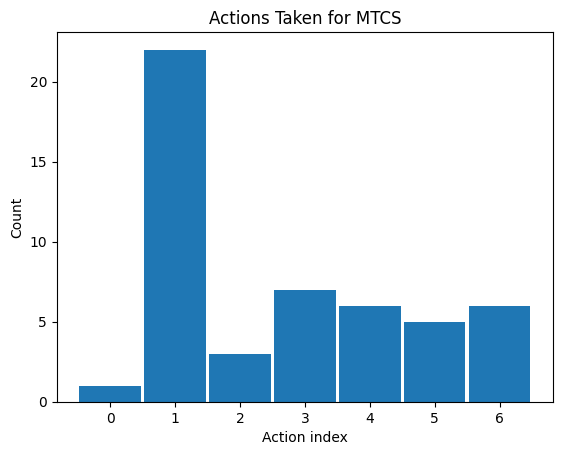

In [106]:
print("Actions and States:")
pprint(index_to_actions_6d)

plt.title("Actions Taken for MTCS")
plt.hist([actions_6d_to_index[a] for a in results], bins=np.arange(-0.5,len(actions_6d),1), rwidth=0.95)
plt.xlabel("Action index")
plt.ylabel("Count")
plt.show()
